In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
%matplotlib inline

In [15]:
start_date = pd.to_datetime('2014-01-01')
end_date = pd.to_datetime('2019-12-31')

# Assuming portfolio consists of 4 stocks = Apple, Nike, Amazon, McDonald's
aapl = web.DataReader('AAPL', 'yahoo', start=start_date, end=end_date)
nike = web.DataReader('NKE', 'yahoo', start=start_date, end=end_date)
amzn = web.DataReader('AMZN', 'yahoo', start=start_date, end=end_date)
mcd = web.DataReader('MCD', 'yahoo', start=start_date, end=end_date)

In [31]:
stocks = pd.concat([aapl['Close'], nike['Close'], amzn['Close'], mcd['Close']], axis=1)
stocks.columns = ['AAPL', 'NIKE', 'AMAZON', 'MCD']

<AxesSubplot:xlabel='Date'>

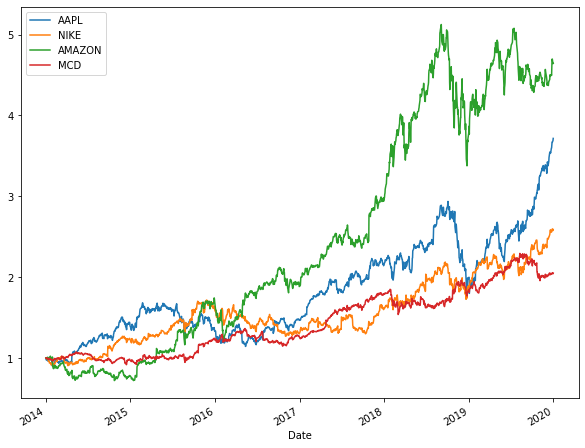

In [34]:
# Visualizing the cumulative returns of each individual stock
cumulative_returns = stocks/stocks.iloc[0]
cumulative_returns.plot(figsize=(10,8))

In [36]:
# Calculating the log returns
log_ret = np.log(stocks / stocks.shift(1))

In [49]:
log_ret

,AAPL,NIKE,AMAZON,MCD
Date,,,,
2014-01-02,NaN,NaN,NaN,NaN
2014-01-03,-0.022211,-0.002688,-0.003852,0.001347
2014-01-06,0.005438,-0.007719,-0.007113,-0.007173
2014-01-07,-0.007177,0.000775,0.011116,0.005514
2014-01-08,0.006313,-0.005175,0.009726,-0.010115
...,...,...,...,...
2019-12-24,0.000950,0.000999,-0.002116,0.002393
2019-12-26,0.019646,0.005676,0.043506,0.001981
2019-12-27,-0.000380,0.008503,0.000551,0.005617


## Monte Carlo Simulations

In [66]:
def get_ret_vol_sr(weights, log_return_mean, log_return_cov):
    """
        Takes in portfolio allocations, and returns the portfolio return, volatility and Sharpe Ratio
    """
    weights = np.array(weights)
    
    # the expected portfoio return
    port_ret = np.sum(log_return_mean * weights)
    
    # the expected portfolio variance/volatility
    port_vol = np.sqrt(np.dot(weights.T, np.dot(log_return_cov, weights)))
    
    # the sharpe ratio
    # assuming the risk free return in the sharpe ratio formula to be 0
    port_sr = port_ret / port_vol
    
    return [port_ret, port_vol, port_sr]

In [91]:
# Going to simulate 20,000 different portfolio possibilities with different weight allocations
num_portfolios = 20000

all_weights = np.zeros((num_portfolios, len(stocks.columns)))
ret_arr = np.zeros(num_portfolios)
vol_arr = np.zeros(num_portfolios)
sr_arr = np.zeros(num_portfolios)

# the annualized log return mean
log_return_mean = log_ret.mean() * 252

# annualized log return covariance matrix
log_return_cov = log_ret.cov() * 252

for i in range(num_portfolios):
    # get the weights
    weights = np.random.random(4)
    
    # rebalance the weights so that the sum is 1
    weights /= np.sum(weights)
    
    # store the weights
    all_weights[i,:] = weights;
    
    # calculate the portfolio return, volatility, and sharpe ratio
    res = get_ret_vol_sr(weights, log_return_mean, log_return_cov)
    
    # store the portfolio return
    ret_arr[i] = res[0]
    
    # store the portfolio volatility
    vol_arr[i] = res[1]
    
    # store the sharpe ratio
    sr_arr[i] = res[2]

In [100]:
# index of the maximum sharpe ratio in the array of sharpe ratios
max_sr_index = sr_arr.argmax()

max_sr_vol = vol_arr[max_sr_index]
max_sr_ret = ret_arr[max_sr_index]

In [131]:
optimal_weight_allocation = all_weights[max_sr_index]
optimal_weight_allocation

array([0.28183003, 0.14404668, 0.21702369, 0.3570996 ])

In [121]:
max_SR = sr_arr[max_sr_index]
max_SR

1.143314410992381

#### Hence the max Sharpe Ratio is 1.143314410992381

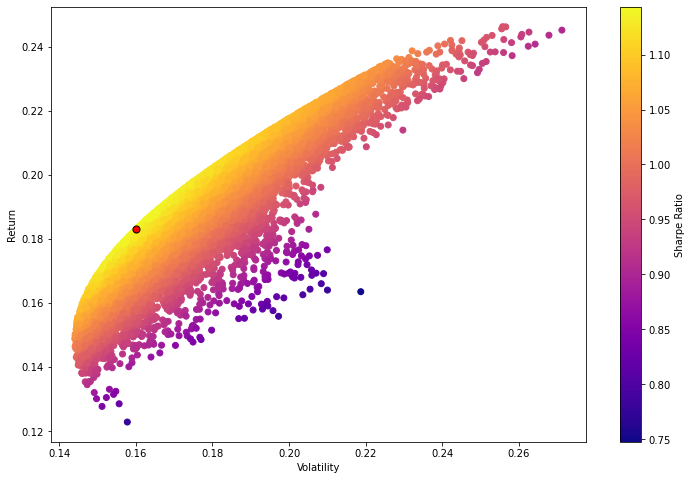

In [101]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sr_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add red dot for max Sharpe Ratio
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')

## Mathematical Optimization and Efficient Frontier

### The way to maximize the Sharpre Ratio is to minimize the negative Sharpe Ratio

In [106]:
from scipy.optimize import minimize

In [110]:
def neg_sharpe(weights):
    """
        Returns negative Sharpe Ratio
    """
    return  get_ret_vol_sr(weights, log_return_mean, log_return_cov)[2] * -1

In [111]:
# Constraints
def check_sum(weights):
    """
        Checking if sum of weights is 1. if it is returns 0 else the difference
    """
    return np.sum(weights) - 1

In [114]:
# The weights should be in the range [0, 1]
bounds = ((0,1), (0,1), (0,1), (0,1))

# Inital guess of the possible weight allocations
init_guess = [0.25, 0.25, 0.25, 0.25]

In [115]:
cons = ({'type': 'eq', 'fun': check_sum})

In [119]:
res = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
optimal_allocation_for_max_SR = res.x
max_SR = get_ret_vol_sr(optimal_allocation_for_max_SR, log_return_mean, log_return_cov)[2]
max_SR

1.1434548969449838

 #### Hence the max Sharpe Ratio calculated using minimization is 1.1434548969449838 which is very similar to the one calculated using Monte Carlo Simulations

In [ ]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights, log_return_mean, log_return_cov)[1]

In [128]:
# List of possible returns or y values that can be attained
# From the plot above it can be seen that the range is [0.12, 0.25]
frontier_y = np.linspace(0.12, 0.25, 100)

In [129]:
frontier_volatility = []

for possible_return in frontier_y:
    cons = ({'type': 'eq', 'fun': check_sum},
            {'type': 'eq', 'fun': lambda weights: 
             get_ret_vol_sr(weights, log_return_mean, log_return_cov)[0] - possible_return})
    
    res = minimize(minimize_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_volatility.append(res['fun'])

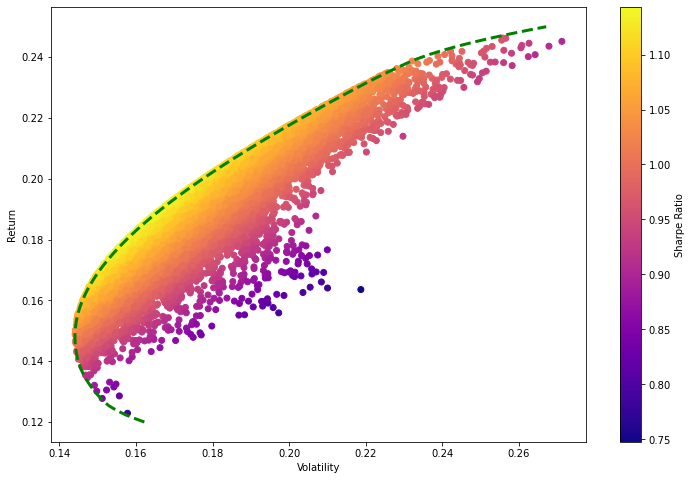

In [130]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sr_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)